# Before you get started

## Data formatting

MINER is optimized for expression data of the form log2(TPM+1) or log2(FPKM+1). Expression data in counts format is not currently supported. 

If expression data is not Homo Sapiens, a reference database must be provided for mechanistic inference.

## Data location

This tutorial will import data stored in the "miner/data" folder. Before you start, move your data to the "miner/data" folder. 

## Special dependencies

These dependencies are not required for coexpression clustering or mechanistic inference, but are employed for optional functions in the miner library

Survival analysis:
    install lifelines

# Begin miner analysis

## Import standard dependencies

In [2]:
import numpy as np
import pandas as pd
from scipy import stats
from numpy import random as rd
import os
import json
from sklearn.decomposition import PCA
import multiprocessing, multiprocessing.pool
import matplotlib.pyplot as plt
import time
from collections import Counter
from sklearn.manifold import TSNE
import miner
%matplotlib inline

## Create directory to save output files

In [10]:
# create name for results folder where output files will be saved
resultsFolder = "results_from_miner_gbm"

# create results directory
resultsDirectory = os.path.join(os.path.split(os.getcwd())[0],resultsFolder)
if not os.path.isdir(resultsDirectory):
    os.mkdir(resultsDirectory)

## Load previous results (skip if results have not previously been generated)

In [1322]:
# If previous results exist, use miner.read_json to load them
revisedClusters = miner.read_json(os.path.join(resultsDirectory,"coexpressionDictionary.json"))
coexpressionModules = miner.read_json(os.path.join(resultsDirectory,"coexpressionModules.json"))
regulons = miner.read_json(os.path.join(resultsDirectory,"regulons.json"))
mechanisticOutput = miner.read_json(os.path.join(resultsDirectory,"mechanisticOutput.json"))

IOError: [Errno 2] No such file or directory: '/Users/MattWall/Desktop/miner/results_gbm_f1Clustering/coexpressionDictionary.json'

## Pre-process expression data

In [14]:
reload(miner)
expressionData = pd.read_csv(os.path.join("..","data","gbmTCGA_exprMat_medianFiltered.csv"),index_col=0,header=0)
expressionData, conversionTable = miner.identifierConversion(expressionData)
expressionData = miner.zscore(expressionData)

completed identifier conversion.
7586 genes were converted.
completed z-transformation.


## Set parameters

In [25]:
# minimum number of genes that form an acceptable coexpression cluster:
minNumberGenes = 6 #bulk RNAseq default=6;single cell RNAseq default=6

# minimum correlation coefficient for an acceptable regulator-cluster association 
minCorrelation = 0.2 #bulk RNAseq default=0.2;single cell RNAseq default=0.05

# minimum number of genes that form an acceptable coexpression cluster and have share binding site for regulator:
minNumberRegulonGenes = 5 #bulk RNAseq default=5;single cell RNAseq default=4

## Co-expression clustering

In [17]:
reload(miner)
# generate a list of coexpressed gene clusters, all of which have length >= minNumberGenes
initialClusters = miner.cluster(expressionData,minNumberGenes = minNumberGenes,minNumberOverExpSamples=4,maxSamplesExcluded=0.50,random_state=12,overExpressionThreshold=80) 
# revise initialClusters to combine highly correlated clusters and keep only those with significant coexpression
revisedClusters = miner.reviseInitialClusters(initialClusters,expressionData)
# write revisedClusters to .json file
miner.write_json(revisedClusters,os.path.join(resultsDirectory,"coexpressionDictionary.json"))

# visualize first 10 clusters
plt.figure(figsize=(8,8))
plt.imshow(expressionData.loc[np.hstack([revisedClusters[i] for i in range(10)]),:],aspect="auto",cmap="viridis",vmin=-1,vmax=1)
plt.grid(False)
plt.ylabel("Genes",FontSize=20)
plt.xlabel("Samples",FontSize=20)
plt.title("First 10 clusters",FontSize=20)

# report coverage
print("Number of genes clustered: {:d}".format(len(set(np.hstack(initialClusters)))))
print("Number of unique clusters: {:d}".format(len(revisedClusters)))

# plot histogram of the cluster size distribution
counts_ = plt.hist([len(revisedClusters[key]) for key in revisedClusters.keys()],bins=100)
plt.xlabel("Number of genes in cluster",FontSize=14)
plt.ylabel("Number of clusters",FontSize=14)

0.00 percent complete
20.00 percent complete
40.00 percent complete
60.00 percent complete
80.00 percent complete

coexpression clustering completed in 1.68 minutes


## Mechanistic inference (only supported for Homo Sapiens)

In [24]:
reload(miner)
t1 = time.time()
# get first principal component axes of clusters
axes = miner.principalDf(revisedClusters,expressionData,subkey=None,minNumberGenes=1)
# analyze revised clusters for enrichment in relational database (default: transcription factor binding site database)
mechanisticOutput = miner.mechanisticInference(axes,revisedClusters,expressionData,correlationThreshold=minCorrelation,dataFolder=os.path.join("..","data"))
# write mechanistic output to .json file
miner.write_json(mechanisticOutput,os.path.join(resultsDirectory,"mechanisticOutput.json"))
# order mechanisticOutput as {tf:{coexpressionModule:genes}} 
coregulationModules = miner.getCoregulationModules(mechanisticOutput)
# write coregulation modules to .json file
miner.write_json(coregulationModules,os.path.join(resultsDirectory,"coregulationModules.json"))
# get final regulons by keeping genes that requently appear coexpressed and associated to a common regulator
regulons = miner.getRegulons(coregulationModules,minNumberGenes=minNumberRegulonGenes,freqThreshold = 0.333)
# reformat regulon dictionary for consistency with revisedClusters and coexpressionModules
regulonModules, regulonDf = miner.regulonDictionary(regulons)
# write regulons to json file
miner.write_json(regulonModules,os.path.join(resultsDirectory,"regulons.json"))
# define coexpression modules as composite of coexpressed regulons
coexpressionModules = miner.getCoexpressionModules(mechanisticOutput)
# write coexpression modules to .json file
miner.write_json(coexpressionModules,os.path.join(resultsDirectory,"coexpressionModules.json"))
#reconvert revised clusters to original gene annotations
annotatedRevisedClusters = miner.convertDictionary(revisedClusters,conversionTable)
# write annotated coexpression clusters to .json file
miner.write_json(revisedClusters,os.path.join(resultsDirectory,"coexpressionDictionary_annotated.json"))
#reconvert results into original annotations
regulonAnnotatedDf = miner.convertRegulons(regulonDf,conversionTable)
#write annotated regulon table to .csv
regulonAnnotatedDf.to_csv(os.path.join(resultsDirectory,"regulons_annotated.csv"))
#reconvert regulons
annotatedRegulons = miner.convertDictionary(regulonModules,conversionTable)
# write annotated regulons to .json file
miner.write_json(regulons,os.path.join(resultsDirectory,"regulons_annotated.json"))
#reconvert coexpression modules
annotatedCoexpressionModules = miner.convertDictionary(coexpressionModules,conversionTable)
# write annotated coexpression modules to .json file
miner.write_json(coexpressionModules,os.path.join(resultsDirectory,"coexpressionModules_annotated.json"))
t2 = time.time()
print("completed mechanistic inference in {:.2f} minutes".format((t2-t1)/60.))
print(len(regulonDf.Regulator.unique()),len(regulonDf.Gene.unique()))

miner.py:696: RuntimeWarning: invalid value encountered in greater_equal
  tfDict[axes[axis]] = tfs[np.where(np.abs(tfCorrelation)>=correlationThreshold)[0]]


0
112
113
225
224
1
114
115
228
226
336
116
227
337
117
338
229
2
339
118
340
448
230
341
449
119
231
342
450
232
120
343
451
3
344
121
233
452
345
346
122
234
347
453
4
123
235
348
454
236
124
349
237
455
125
350
238
456
5
351
457
126
239
352
458
353
459
240
127
241
460
354
461
242
128
243
462
355
356
463
129
464
357
244
465
130
6
358
466
359
467
245
468
131
469
360
246
470
132
361
247
7
471
362
472
248
133
473
249
363
250
474
134
475
364
476
251
8
135
252
477
365
478
366
253
136
9
367
479
254
368
137
480
369
255
138
481
370
256
10
482
371
139
257
483
372
484
258
373
485
140
259
374
486
487
375
260
11
488
376
141
377
378
489
261
379
142
490
262
380
12
143
491
263
381
492
144
264
382
13
493
265
383
494
145
266
14
495
384
267
146
496
385
268
15
386
147
497
269
387
270
148
388
389
498
271
16
499
149
390
272
500
391
273
392
150
17
501
274
393
502
151
275
394
152
18
503
395
276
396
504
277
153
397
19
505
154
278
155
398
279
506
156
399
507
280
400
508
281
157
20
401
509
282
402
403
510
158

## Infer bicluster membership

In [80]:
# select reference dictionary for downstream analysis (revisedClusters, coexpressionModules, or regulonModules)
referenceDictionary = regulonModules
# create a background matrix used for statistical hypothesis testing
bkgd = miner.backgroundDf(expressionData)
# for each cluster, give samples that show high coherent cluster activity
overExpressedMembers = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label=2,p=0.1)
# for each cluster, give samples that show low coherent cluster activity
underExpressedMembers = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label=0,p=0.1)
# for each cluster, give samples that do not show coherent cluster activity
dysregulatedMembers = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label="excluded")
# for each cluster, give samples that show coherent cluster activity, despite magnitude of expression
coherentMembers = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label="included")

# write membership matrices to .csv file
overExpressedMembersMatrix = miner.membershipToIncidence(overExpressedMembers,expressionData)
overExpressedMembersMatrix.to_csv(os.path.join(resultsDirectory,"overExpressedMembers.csv"))
underExpressedMembersMatrix = miner.membershipToIncidence(underExpressedMembers,expressionData)
underExpressedMembersMatrix.to_csv(os.path.join(resultsDirectory,"underExpressedMembers.csv"))
dysregulatedMembersMatrix = miner.membershipToIncidence(dysregulatedMembers,expressionData)
dysregulatedMembersMatrix.to_csv(os.path.join(resultsDirectory,"dysregulatedMembers.csv"))
coherentMembersMatrix = miner.membershipToIncidence(coherentMembers,expressionData)
coherentMembersMatrix.to_csv(os.path.join(resultsDirectory,"coherentMembers.csv"))

done!
done!
done!
done!


## Infer subtypes

In [64]:
# choose membership type for sample class prediction
sampleDictionary = overExpressedMembers
sampleMatrix = overExpressedMembersMatrix
sampleUnderMatrix = underExpressedMembersMatrix

# perform initial subtype clustering
similarityClusters = miner.f1Decomposition(sampleDictionary,thresholdSFM=0.1)
initialClasses = [i for i in similarityClusters if len(i)>4]

# visualize initial results
sampleFrequencyMatrix = miner.sampleCoincidenceMatrix(sampleDictionary,freqThreshold = 0.333,frequencies=True) #0.333
similarityMatrix = sampleFrequencyMatrix*sampleFrequencyMatrix.T
miner.plotSimilarity(similarityMatrix,np.hstack(initialClasses),vmin=0,vmax=0.5,title="Similarity matrix",xlabel="Samples",ylabel="Samples",fontsize=14,figsize=(7,7),savefig=os.path.join(resultsDirectory,"similarityMatrix_regulons.pdf"))

# expand initial subtype clusters
centroidClusters, centroidMatrix = miner.centroidExpansion(initialClasses,sampleMatrix,f1Threshold = 0.1,returnCentroids=True) #0.3
centroidMatrix.to_csv(os.path.join(resultsDirectory,"centroids.csv"))
unmapped = list(sampleMatrix.columns[np.where(sampleMatrix.sum(axis=0)==0)[0]])
mappedSamples = [i for i in np.hstack(centroidClusters) if i not in unmapped]
mappedClusters = miner.mapExpressionToNetwork(centroidMatrix,sampleMatrix,threshold = 0.05)

# visualize expanded subtype clusters
miner.plotSimilarity(similarityMatrix,mappedSamples,vmin=0,vmax=0.333,title="Similarity matrix",xlabel="Samples",ylabel="Samples",fontsize=14,figsize=(7,7),savefig=os.path.join(resultsDirectory,"centroidClusters_regulons.pdf"))

# Generate heatmaps of module activity
orderedOverExpressedMembers = miner.orderMembership(centroidMatrix,sampleMatrix,mappedClusters,ylabel="Modules",resultsDirectory=None)
orderedDM = miner.plotDifferentialMatrix(overExpressedMembersMatrix,underExpressedMembersMatrix,orderedOverExpressedMembers,cmap="bwr",aspect="auto",saveFile=os.path.join(resultsDirectory,"centroid_clusters_heatmap.pdf"))

# Infer transcriptional programs and states
programs, states = miner.mosaic(dfr=orderedDM,clusterList=centroidClusters,minClusterSize_x=9,minClusterSize_y=5,allow_singletons=False,max_groups=50,saveFile=os.path.join(resultsDirectory,"regulon_activity_heatmap.pdf"),random_state=12)   
transcriptional_programs, program_regulons = miner.transcriptionalPrograms(programs,referenceDictionary)
program_list = [program_regulons[("").join(["TP",str(i)])] for i in range(len(program_regulons))]
mosaicDf = orderedDM.loc[np.hstack(program_list),np.hstack(states)]
mosaicDf.to_csv(os.path.join(resultsDirectory,"regulons_activity_heatmap.csv"))

# Get eigengenes for all modules
eigengenes = miner.getEigengenes(referenceDictionary,expressionData,regulon_dict=None,saveFolder=None)

#write eigengenes to .csv
eigengenes.to_csv(os.path.join(resultsDirectory,"eigengenes.csv"))

#plot eigengenes
plt.imshow(eigengenes.loc[np.hstack(program_list),np.hstack(states)],cmap="viridis",vmin=-0.05,vmax=0.05,aspect="auto")
plt.grid(False)

# calculate percent of samples that fall into a state with >= minimum acceptable number of samples
groups = [states[i] for i in range(len(states)) if len(states[i])>=int(np.ceil(0.01*expressionData.shape[1]))]
print('Discovered {:d} transcriptional states and {:d} transcriptional programs'.format((len(states)),len(transcriptional_programs)))
print('sample coverage within sufficiently large states: {:.1f}%'.format(100*float(len(np.hstack(groups)))/expressionData.shape[1]))

#write all transcriptional program genesets to text files for external analysis
if not os.path.isdir(os.path.join(resultsDirectory,"transcriptional_programs_coexpressionModules")):
    os.mkdir(os.path.join(resultsDirectory,"transcriptional_programs_coexpressionModules"))
    
for tp in transcriptional_programs.keys():
    np.savetxt(os.path.join(resultsDirectory,"transcriptional_programs_coexpressionModules",(".").join([tp,"txt"])),transcriptional_programs[tp],fmt="%1.50s")
    
# Determine activity of transcriptional programs in each sample
statesDf = miner.reduceModules(df=orderedDM,programs=program_list,states=states,stateThreshold=0.65,saveFile=os.path.join(resultsDirectory,"transcriptional_programs_vs_samples.pdf"))

# Cluster patients into subtypes and give the activity of each program in each subtype
programsVsStates = miner.programsVsStates(statesDf,states,filename=os.path.join(resultsDirectory,"programs_vs_states.pdf"))

# Visualize with tSNE

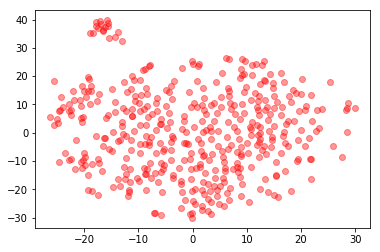

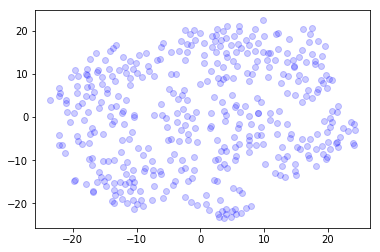

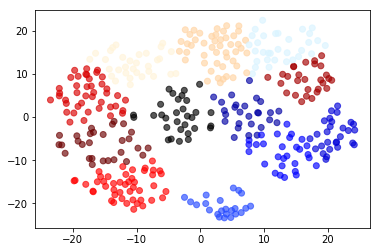

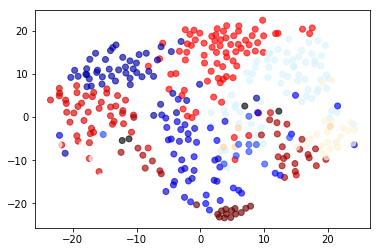

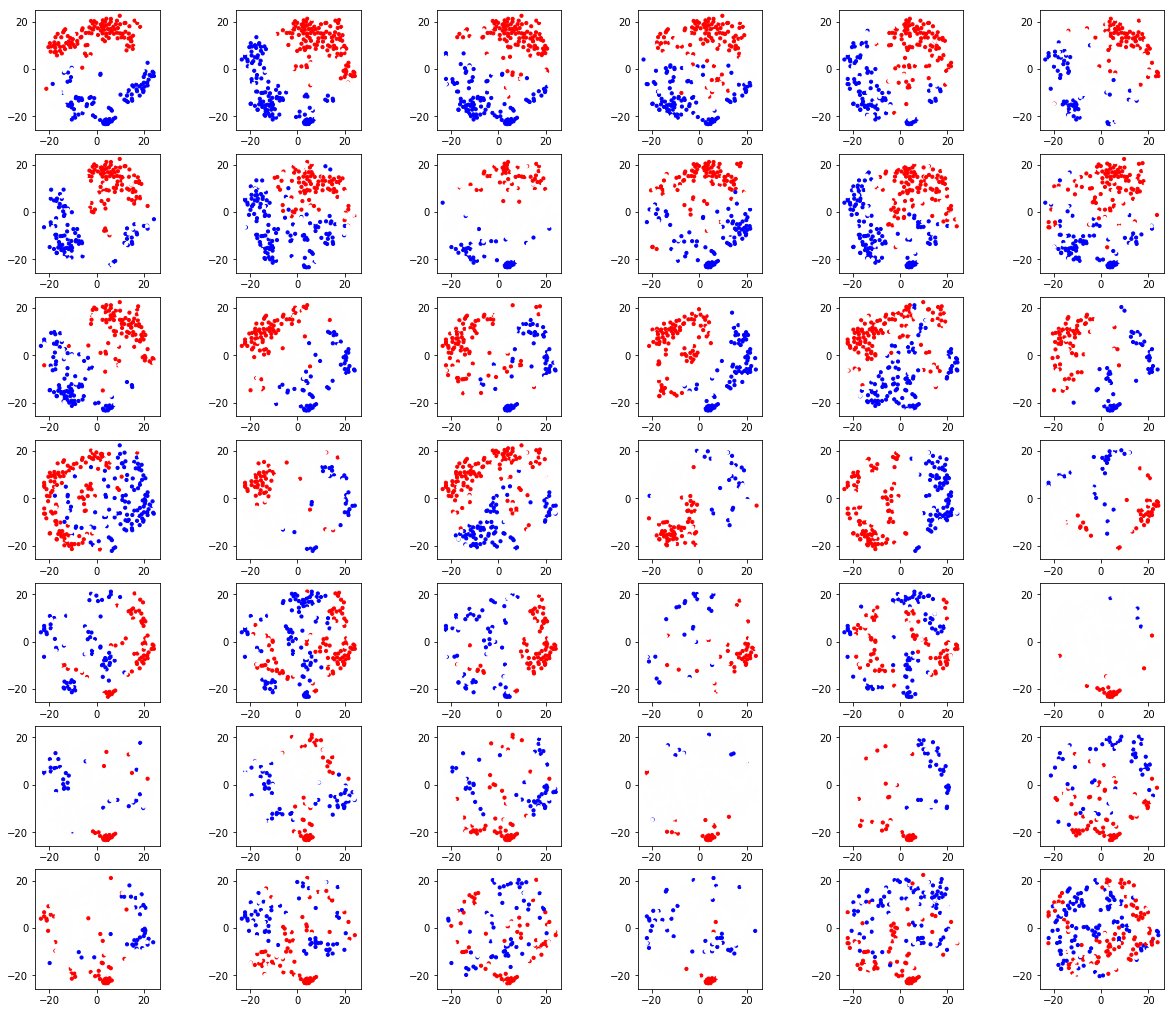

In [91]:
# tSNE applied to expressionData. Set plotOnly = False to return tSNE coordinates
# consider changing the perplexity to explore different degrees of cluster separation
miner.tsne(expressionData,perplexity=15,n_components=2,n_iter=1000,plotOnly=True,plotColor="red",alpha=0.4)
plt.savefig(os.path.join(resultsDirectory,"tsne_gene_expression.pdf"),bbox_inches="tight")

# tSNE applied to df_for_tsne. Consider changing the perplexity in the range of 5 to 50
df_for_tsne = mosaicDf.copy()
plt.figure()
X_embedded = miner.tsne(df_for_tsne,perplexity=30,n_components=2,n_iter=1000,plotOnly=None,plotColor="blue",alpha=0.2)
tsneDf = pd.DataFrame(X_embedded)
tsneDf.index = df_for_tsne.columns
tsneDf.columns = ["tsne1","tsne2"]
plt.savefig(os.path.join(resultsDirectory,"tsne_regulon_activity.pdf"),bbox_inches="tight")

# How many clusters do you expect? Start with number of states
numberOfClusters = len(states)

# Are the clusters separated how you thought? If not, change the random_state to a different number and retry
random_state=12

clusters, labels, centroids = miner.kmeans(tsneDf,numClusters=numberOfClusters,random_state=random_state)

# overlay kmeans cluster labels
plt.figure()
plt.scatter(tsneDf.iloc[:,0],tsneDf.iloc[:,1],cmap="flag",c=labels,alpha=0.65)
plt.savefig(os.path.join(resultsDirectory,"labeled_tsne_kmeans.pdf"),bbox_inches="tight")

# convert states to tsne labels
state_labels = miner.tsneStateLabels(tsneDf,states)

# overlay states cluster labels
plt.figure()
plt.scatter(tsneDf.iloc[:,0],tsneDf.iloc[:,1],cmap="flag",c=state_labels,alpha=0.65)
plt.savefig(os.path.join(resultsDirectory,"labeled_tsne_states.pdf"),bbox_inches="tight")

# overlay activity of transcriptional programs
miner.plotStates(statesDf,tsneDf,numCols=int(np.sqrt(statesDf.shape[0])),saveFile = os.path.join(resultsDirectory,("_").join(["states_regulons",("").join(["0o",str(minCorrelation).split(".")[1]]),"tsne.pdf"])),aspect=1,size=10,scale=3)

# Survival analysis

In [1306]:
# load survival data
survivalMMRF = pd.read_csv(os.path.join("..","data","survivalIA12.csv"),index_col=0,header=0)
survivalDfMMRF = survivalMMRF.iloc[:,0:2]
survivalDfMMRF.columns = ["duration","observed"]
overExpressedMembersMatrixMMRF = overExpressedMembersMatrix
overExpressedMembersMatrixMMRF = overExpressedMembersMatrixMMRF.loc[orderedOverExpressedMembers.index,:]

#generate Kaplan-Meier estimates
kmDf = miner.kmAnalysis(survivalDf=survivalDfMMRF,durationCol="duration",statusCol="observed")
#generate GuanRank scores
guanSurvivalDfMMRF = miner.guanRank(kmSurvival=kmDf)

# Visualize risk associated with each transcriptional state

srv = guanSurvivalDfMMRF.copy()
guan_srv = pd.DataFrame(srv.loc[:,"GuanScore"])
guan_srv.columns = ["value"]
guan_srv_group = pd.DataFrame(-np.ones(guan_srv.shape[0]))
guan_srv_group.index = guan_srv.index
guan_srv_group.columns = ["group"]
guan_srv_df = pd.concat([guan_srv,guan_srv_group],axis=1)

mmrf_groups = states

labels = range(len(mmrf_groups))

xmedians = []
for i in range(len(mmrf_groups)):
    group = list(set(srv.index)&set(mmrf_groups[i]))
    if len(group)>=1:
        xmedians.append(np.median(guan_srv_df.loc[group,"value"]))
    elif len(group)<1:
        xmedians.append(0)
    label = labels[i]
    guan_srv_df.loc[group,"group"] = label
print(len(xmedians))
    
import seaborn as sns
survival_tag = "Risk_groups"
plt.figure(figsize=(12,8))
ax = sns.boxplot(x='group', y='value', data=guan_srv_df,order=np.argsort(xmedians))
for patch in ax.artists:
    patch.set_edgecolor('black')
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 0.8))

sns.swarmplot(x='group', y='value',data=guan_srv_df,order=np.argsort(xmedians),size=5, color=[0.15,0.15,0.15],edgecolor="black")
    
plt.ylabel("Risk score",FontSize=20)
plt.xlabel("Subtype",FontSize=20)
boxplotFilename = ("_").join([survival_tag,"boxplot_swarm.pdf"])
plt.savefig(os.path.join(resultsDirectory,boxplotFilename),bbox_inches="tight")


# proportional hazards regression of transcriptional programs
cox_programs = miner.parallelMemberSurvivalAnalysis(membershipDf = statesDf,numCores=5,survivalPath="",survivalData=srv)

cox_programs_hr = [cox_programs[i][0] for i in range(len(cox_programs))]
cox_programs_p = [cox_programs[i][1] for i in range(len(cox_programs))]
cox_programs_df = pd.DataFrame(np.vstack([cox_programs_hr,cox_programs_p]).T)
cox_programs_df.index = [cox_programs.keys()[i] for i in range(len(cox_programs))]
cox_programs_df.columns = ["HR","p-value"]
cox_programs_df.sort_values(by="HR",ascending=False,inplace=True)

# proportional hazards regression of transcriptional states
state_members = [states[i] for i in range(len(states)) if len(states[i])>=9]
sufficient_states = [i for i in range(len(states)) if len(states[i])>=9]
state_survival = pd.DataFrame(np.zeros((len(state_members),srv.shape[0])))
state_survival.index = sufficient_states
state_survival.columns = srv.index
for ix in range(len(sufficient_states)):
    sm = list(set(state_members[ix])&set(srv.index))
    state_survival.loc[sufficient_states[ix],sm] = 1
    
cox_states = miner.parallelMemberSurvivalAnalysis(membershipDf = state_survival,numCores=5,survivalPath="",survivalData=srv)

cox_hr = [cox_states[i][0] for i in cox_states.keys()]
cox_p = [cox_states[i][1] for i in cox_states.keys()]
cox_df = pd.DataFrame(np.vstack([cox_hr,cox_p]).T)
cox_df.index = cox_states.keys()
cox_df.columns = ["HR","p-value"]
cox_df.sort_values(by="HR",ascending=False,inplace=True)

## Causal inference

In [3356]:
reload(miner)
miner.generateCausalInputs(expressionData,mechanisticOutput,coexpressionModules,saveFolder=resultsDirectory,regulon_dict=regulons,mutationFile="translocationsIA12.csv")    

## Pause to run NEO using the minerNEO notebook

## Continue causal inference

In [3360]:
# After running NEO (in R), proceed with the following
preProcessedCausalResults = miner.processCausalResults(causalPath=os.path.join("..","results","causal"))
# load complete mutation matrix with default filters for use in postprocessing
filteredMutations = miner.mutationMatrix(mutationPath=os.path.join(os.path.expanduser("~"),"Desktop","miner","data"),mutationFiles = ["filteredMutationsIA12.csv","translocationsIA12.csv"],minNumMutations=None)
# load tf expression matrix for use in postprocessing
tfExp = miner.tfExpression(expressionData,motifPath=os.path.join("..","data","all_tfs_to_motifs.pkl"))
# load eigengenes matrix for use in postprocessing
eigengenes = pd.read_csv(os.path.join(os.path.expanduser("~"),"Desktop","miner","results","eigengenes.csv"),index_col=0,header=0)
# generate p values for all network edges for use in filtering
postProcessedCausalAnalysis = miner.postProcessCausalResults(preProcessedCausalResults,filteredMutations,tfExp,eigengenes,mechanisticOutput=None,numCores=5)
# write post-processed analysis to json file       
miner.write_json(postProcessedCausalAnalysis,os.path.join(os.path.expanduser("~"),"Desktop","miner","results","regulonNetworkPValues.json"))     
# generate causal mechanistic network in dataframe format
causalMechanisticNetwork = miner.causalMechanisticNetworkDictionary(postProcessedCausalAnalysis,biclusterRegulatorPvalue=0.05,regulatorMutationPvalue=0.05,mutationFrequency = 0.01,requireCausal=True)
# save causalMechanisticNetwork to csv
causalMechanisticNetwork.to_csv(os.path.join(os.path.expanduser("~"),"Desktop","miner","results","regulonCausalMechanisticNetwork.csv"))


0
0
0
0
10
0
10
10
20
20
30
10
10
20
30
30
20
40
40
50
30
60
50
70
40
20
60
80
70
50
90
60
80
40
100
70
90
110
80
100
120
30
110
90
130
50
100
120
140
40
110
120
60
130
130
150
140
140
150
160
160
50
150
170
170
70
160
180
170
190
180
60
180
200
80
210
190
190
220
200
230
70
200
210
240
90
210
220
220
250
230
230
260
100
80
240
250
110
240
270
260
90
270
280
120
250
290
280
130
260
140
300
270
150
280
310
290
100
320
290
160
300
330
300
340
350
310
170
310
320
110
320
180
330
330
340
360
340
190
370
350
200
380
120
350
390
360
400
210
370
410
360
220
380
420
370
230
430
390
400
380
240
130
410
250
440
260
390
450
420
460
270
400
470
140
480
430
410
280
420
440
490
430
500
450
510
290
460
150
440
450
470
300
460
480
160
470
520
490
480
500
510
490
310
520
500
530
530
510
540
170
520
550
530
540
550
540
560
550
570
320
180
560
560
580
570
330
590
580
340
570
190
600
590
350
610
600
620
360
580
610
630
370
200
620
640
380
590
630
650
210
390
600
660
640
400
650
660
610
410
620
420
430
220